In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

In [43]:
import pathlib

path=str(pathlib.Path().resolve())+"\\Faces"

In [44]:
def get_from_dir(dir):
    global path
    dir = os.path.join(path,dir)
    return tf.keras.utils.image_dataset_from_directory(
           dir,
           labels='inferred',
           color_mode="rgb",
           seed=42,
           batch_size=32,
           image_size=(128, 128))

train = get_from_dir("Train")
test = get_from_dir("Test")
val = get_from_dir("Validation")

Found 140002 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.


In [45]:
for images, labels in train.take(1):
    print("Etiqueta de la primera imagen:", labels[0].numpy())

Etiqueta de la primera imagen: 1


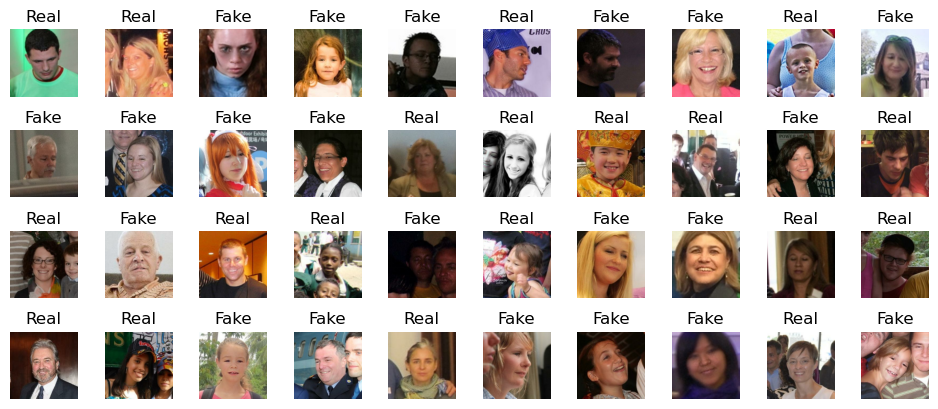

In [46]:
from matplotlib import pyplot as plt

class_names = np.unique(train.class_names)

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
data = list(train.take(n_rows*n_cols))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        # Obtener solo la primera imagen del lote
        single_image = data[index][0][0]  # Tomar la primera imagen del primer lote
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(single_image.numpy().astype("uint8"),cmap="gray")  # Convertir a tipo uint8 para imshow
        plt.axis('off')
        # Convertir a un solo valor antes de usarlo para indexar class_names
        label_index = data[index][1][0]
        plt.title(class_names[label_index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


# Model Processing

In [54]:
model = models.Sequential()

# Va hacer 32 Kernels que serán 3X3 es decir
# Recogera de cada 3 pixeles el central para la nueva imagen 
# Podríamos indicar los Strides (1,1) que son las casillas que avanza
# Le decimos que sea 28 x 28 y que tenga un canal
model.add(layers.Conv2D(32,(3,3),activation="relu", padding='same',input_shape=(128,128,3)))

# Se va reduciendo la imagen por lo que podemos aumentar el número de filtros, donde la imagen se nos va a la mitad
model.add(layers.MaxPooling2D((2,2), strides=(2, 2)))

# Lo normal es aumentar el número de filtros en la imagen
model.add(layers.Conv2D(64,(3,3),activation="relu", padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2, 2)))


model.add(layers.Conv2D(128,(3,3),activation="relu", padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2, 2)))

# Aplana la capa actual
#model.add(layers.Conv2D(128,(3,3),activation="relu"))
#model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.Flatten())

model.add(layers.Dropout(0.5))

model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 16, 16, 128)      

In [55]:
model.compile('adam',loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:

import sys

#gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)
#tf.config.set_visible_devices([], 'CPU') # hide the CPU
#tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
#tf.config.get_visible_devices()


#cpus = tf.config.experimental.list_physical_devices('CPU')
#print(cpus)
#tf.config.set_visible_devices([], 'GPU')  # hide the GPU
#tf.config.set_visible_devices(cpus[0], 'CPU') # unhide potentially hidden CPU
#tf.config.get_visible_devices()

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)


history = model.fit(train,epochs=sys.maxsize,batch_size=32,validation_data=val,callbacks=[early_stopping_cb])

In [57]:
model.save("modelo_detector_caras.keras")

In [95]:
test.shuffle = False

In [121]:
predicciones = model.predict(test)
predicciones = (predicciones >= 0.5).astype(int)

341/341 [==============================] - 17s 49ms/step


1/1 [==============================] - 0s 46ms/step


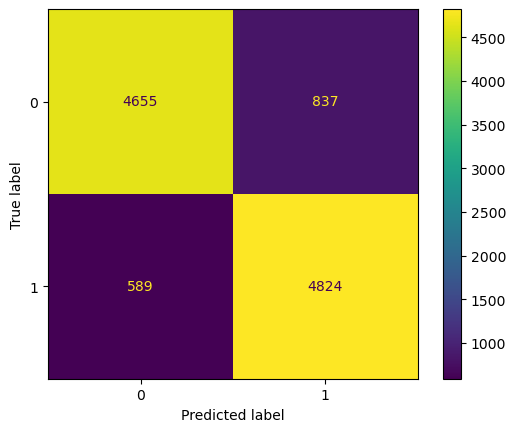

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las etiquetas verdaderas y las predicciones
true_labels = []
predictions = []

for images, labels in test:
    true_labels.extend(labels.numpy())
    batch_predictions = model.predict(images) >= 0.5
    predictions.extend(batch_predictions.astype(int).flatten())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

